In [1]:
import numpy
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
import matplotlib as plt
plt.rcParams["figure.figsize"] = (10, 5)
import sys, glob
import urllib3
import h5py
import cdsapi, zipfile, os, time
import warnings
import shutil
import xarray
from datetime import date
# warnings.filterwarnings('ignore')
# import pycountry
sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua3 as eua
import numba
import copy
import glob
from numba import njit
import pandas
import glob
import pickle
import multiprocessing
from functools import partial
import requests
sys.path.insert(0,os.getcwd()+'/../resort/rasotools-master/')
import rasotools
import xarray as xr
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]


/tmp/ipykernel_930624/677895260.py:7: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [45]:
statid = '50527'
adj = 'RISE'
statlist = glob.glob('/mnt/users/scratch/leo/scratch/converted_v7/*' + statid + '*_CEUAS_merged_v1.nc')

if adj == None:
    df = eua.CDMDataset(filename = statlist[0]).to_dataframe(groups=['observations_table'], variables=['observed_variable', 'observation_value', 'date_time', 'z_coordinate', 'latitude', 'longitude'])
else:
    df = eua.CDMDataset(filename = statlist[0]).to_dataframe(groups=['observations_table', 'advanced_homogenisation'], variables=['observed_variable', 'observation_value', 'date_time', 'z_coordinate', 'latitude', 'longitude', adj+'_bias_estimate','humidity_bias_estimate'])
###
df = df[df.z_coordinate.isin([3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000])]
df = df[df.date_time > '1979']
df = df.rename({'latitude':'lat','longitude':'lon', 'date_time':'time', 'z_coordinate':'plev'}, axis='columns')

all_dfsh = df[df.observed_variable == 38]
all_dfsh = all_dfsh.rename({'observation_value':'hus'}, axis='columns')

all_dfta = df[df.observed_variable == 85]
all_dfta = all_dfta.rename({'observation_value':'ta'}, axis='columns')

###
if adj != None:
#     all_dfta.ta = all_dfta.ta - all_dfta[adj+'_bias_estimate']
    all_dfsh.hus = all_dfsh.hus - all_dfsh['humidity_bias_estimate']
###

tadata = []
daydata = []
datedata = []
humdata = []
eradata = []
chandata = []
pressdata = []
mondata = []

wholemon = []

for day in [True]:
    if day:
        dn_dfta = all_dfta[all_dfta.time.dt.hour > 6][all_dfta.time.dt.hour <= 18]
        dn_dfsh = all_dfsh[all_dfsh.time.dt.hour > 6][all_dfsh.time.dt.hour <= 18]
    else:
        dn_dfta = all_dfta[all_dfta.time.dt.hour <= 6].append(all_dfta[all_dfta.time.dt.hour > 18]).sort_values(by='time')
        dn_dfsh = all_dfsh[all_dfsh.time.dt.hour <= 6].append(all_dfsh[all_dfsh.time.dt.hour > 18]).sort_values(by='time')

    for yr in range(1979,2022,1):
        for mon in range(int(str(yr)+'01'), int(str(yr)+'13'), 1):
            wholemon.append(mon)
            dfta = dn_dfta.loc[(dn_dfta['time'].dt.year==int(str(mon)[:4])) & (dn_dfta['time'].dt.month==int(str(mon)[-2:]))]
            df = dfta
            mon_mean = df.groupby(['plev']).aggregate({"ta":np.mean})
            dfsh = dn_dfsh.loc[(dn_dfsh['time'].dt.year==int(str(mon)[:4])) & (dn_dfsh['time'].dt.month==int(str(mon)[-2:]))]
            reduced_sh = dfsh.groupby(['plev']).aggregate({"hus":np.mean})
            for j in [3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000]:
                if len(df[df.plev == j]) < 1:
                    mon_mean = mon_mean[mon_mean.index != j]
                    reduced_sh = reduced_sh[reduced_sh.index != j]

            if len(mon_mean) >= 9:
                with xarray.open_dataset('./era/era_'+str(yr)+'.nc') as era:
                    era_input = era.sel(time = str(yr)+'-'+str(mon)[-2:]+'-01T00:00:00.000000000', latitude = dfta.lat.iloc[0], longitude = dfta.lon.iloc[0], method='nearest')
                date = pd.to_datetime(float(era_input.time))
#                     high_mon_mean = mon_mean[mon_mean.index.isin([3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000])]
#                     high_hum_mean = reduced_sh[reduced_sh.index.isin([3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,70000,85000])]
                high_mon_mean = mon_mean[mon_mean.index.isin([10000,15000,20000,25000,30000,40000,50000,70000,85000])]
                high_hum_mean = reduced_sh[reduced_sh.index.isin([10000,15000,20000,25000,30000,40000,50000,70000,85000])]
                high_hum_mean = high_hum_mean[high_hum_mean.index.isin(high_mon_mean.index)]
                high_mon_mean = high_mon_mean[high_mon_mean.index.isin(high_hum_mean.index)]

                if len(high_mon_mean) >= 9:
                    plevs_to_check = high_mon_mean.index
#                         if((3000 in plevs_to_check and 5000 in plevs_to_check and 7000 in plevs_to_check and 10000 in plevs_to_check and 
                    if((10000 in plevs_to_check and 
                            15000 in plevs_to_check and 20000 in plevs_to_check and 25000 in plevs_to_check and 
                            30000 in plevs_to_check and 40000 in plevs_to_check and 50000 in plevs_to_check)):
                        if(not (70000 in plevs_to_check)):
                            s = high_mon_mean.iloc[0]
                            s.ta = np.nan
                            s.name = 70000
                            high_hum_mean = high_hum_mean.append(s)
                            high_mon_mean = high_mon_mean.append(s)
                        if(not (85000 in plevs_to_check)):
                            s = high_mon_mean.iloc[0]
                            s.ta = np.nan
                            s.name = 85000
                            high_hum_mean = high_hum_mean.append(s)
                            high_mon_mean = high_mon_mean.append(s)

                        tadata.append(high_mon_mean.ta)
#                         humdata.append(high_hum_mean.hus)
                        humdata.append(rasotools.met.convert.to_sh(temp=xr.DataArray(high_mon_mean.ta), press=xr.DataArray(high_mon_mean.index), 
                                                                   rel_humi=xr.DataArray(high_hum_mean.hus)).values)
                        pressdata.append(high_mon_mean.index)
                        datedata.append(date)

/tmp/ipykernel_930624/4041267099.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dn_dfta = all_dfta[all_dfta.time.dt.hour > 6][all_dfta.time.dt.hour <= 18]
/tmp/ipykernel_930624/4041267099.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dn_dfsh = all_dfsh[all_dfsh.time.dt.hour > 6][all_dfsh.time.dt.hour <= 18]


In [46]:
# name = []
# sh = []
# shdates = []

In [47]:
name.append('sh_rh_unadj_temp_day')
sh.append(humdata)
shdates.append(datedata)

In [48]:
display(name)

['sh_day', 'sh_rh_day', 'sh_rh_adj_day', 'sh_rh_unadj_temp_day']

In [49]:
# shdates.remove(shdates[1])

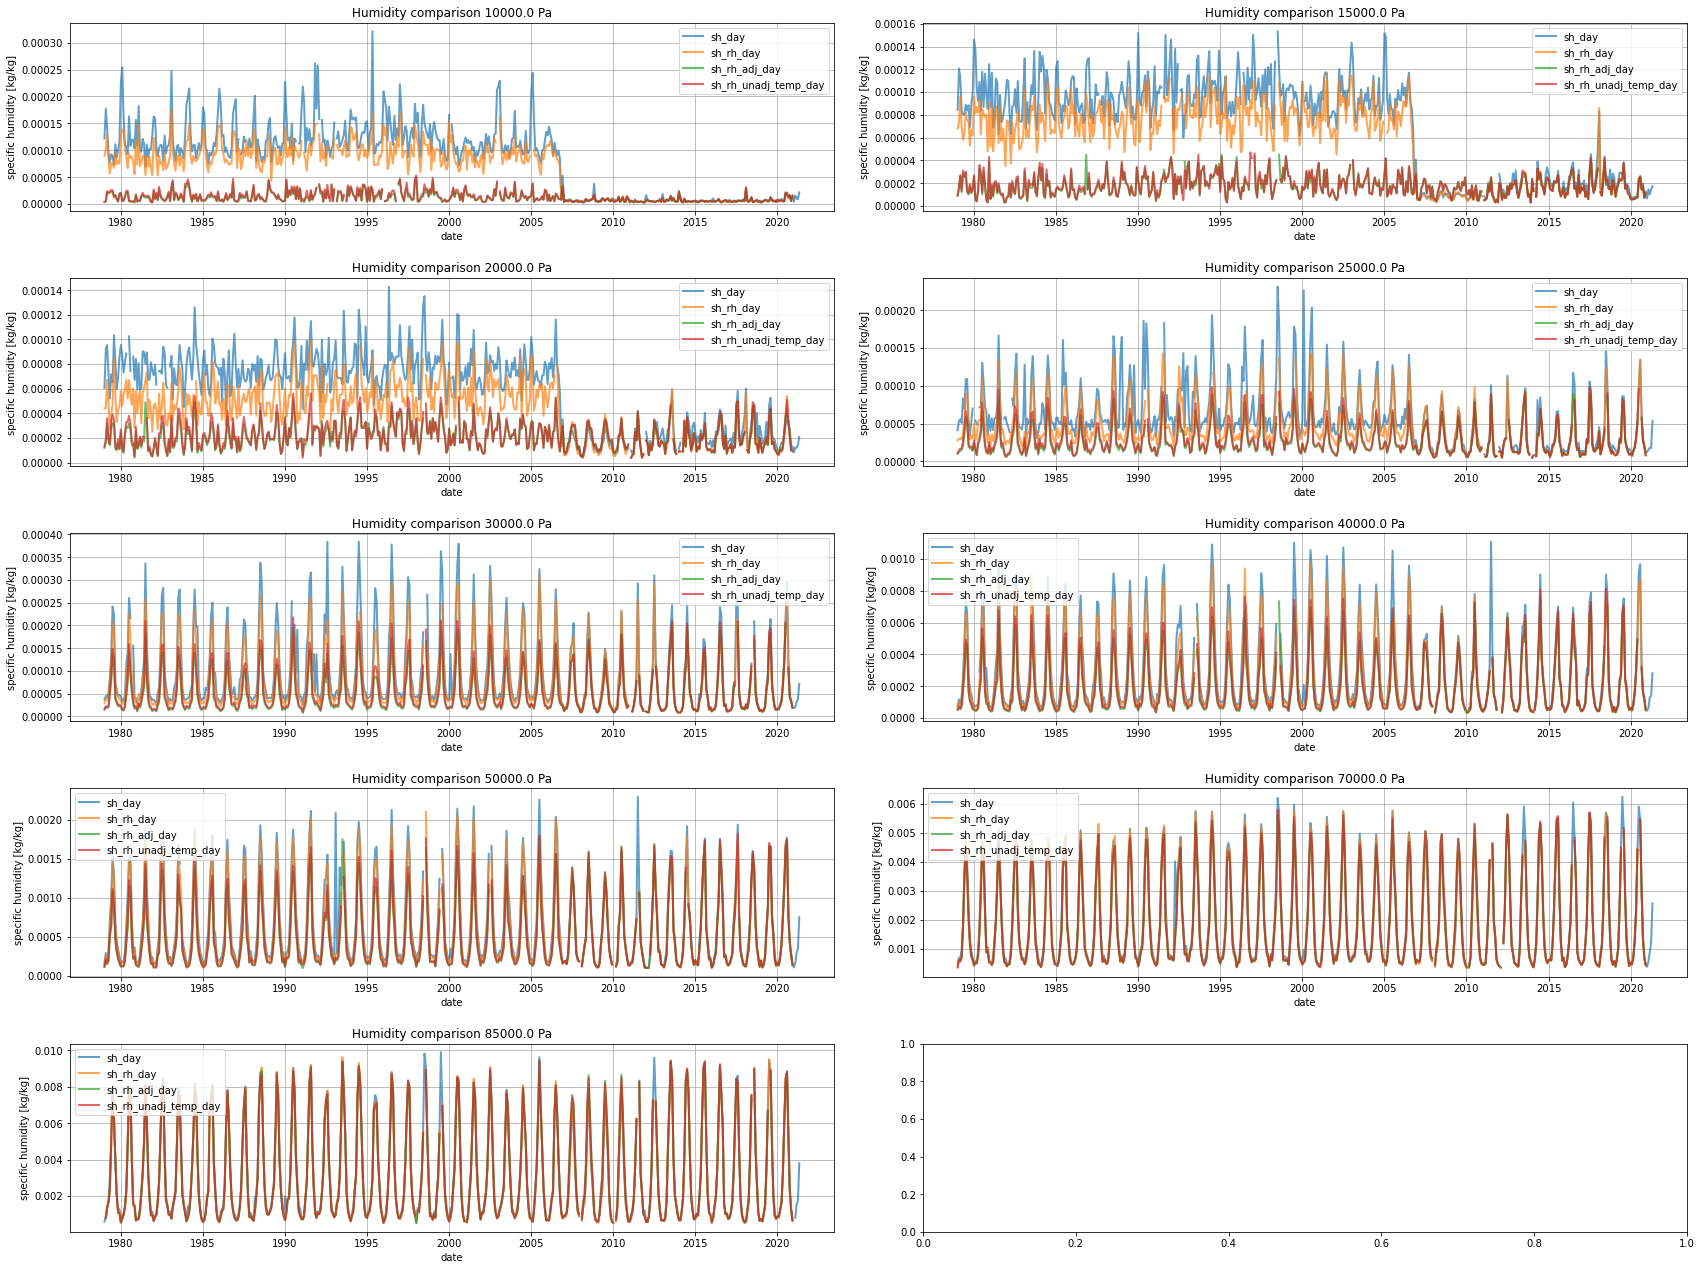

In [50]:
plt.rcParams['figure.figsize'] = [24, 18]


fig, axs = plt.subplots(5, 2)
axs = axs.ravel()
for i in range(len(pressdata[0])):
    axs[i].grid()
    axs[i].set(xlabel='date', ylabel='specific humidity [kg/kg]',
       title='Humidity comparison '+ str(pressdata[0][i])+' Pa')
    for j in range(len(name)):
        hum_to_plot = np.array(sh[j])[:,i]
        hum_to_plot[hum_to_plot > np.nanquantile(hum_to_plot, 0.99)] = np.nan
        hum_to_plot[hum_to_plot < np.nanquantile(hum_to_plot, 0.01)] = np.nan
        axs[i].plot(shdates[j], hum_to_plot, label=name[j], linewidth=2, alpha=0.7)

    axs[i].legend()
#     ax2 = axs[i].twinx()
#     ax2.plot(datedata, np.array(tadata)[:,i], color='red', label='adjusted_temperature', linewidth=2, alpha=0.3)
#     ax2.set(xlabel='date', ylabel='temperature [K]')
#     ax2.legend()
fig.tight_layout(pad=2.0)
plt.show()

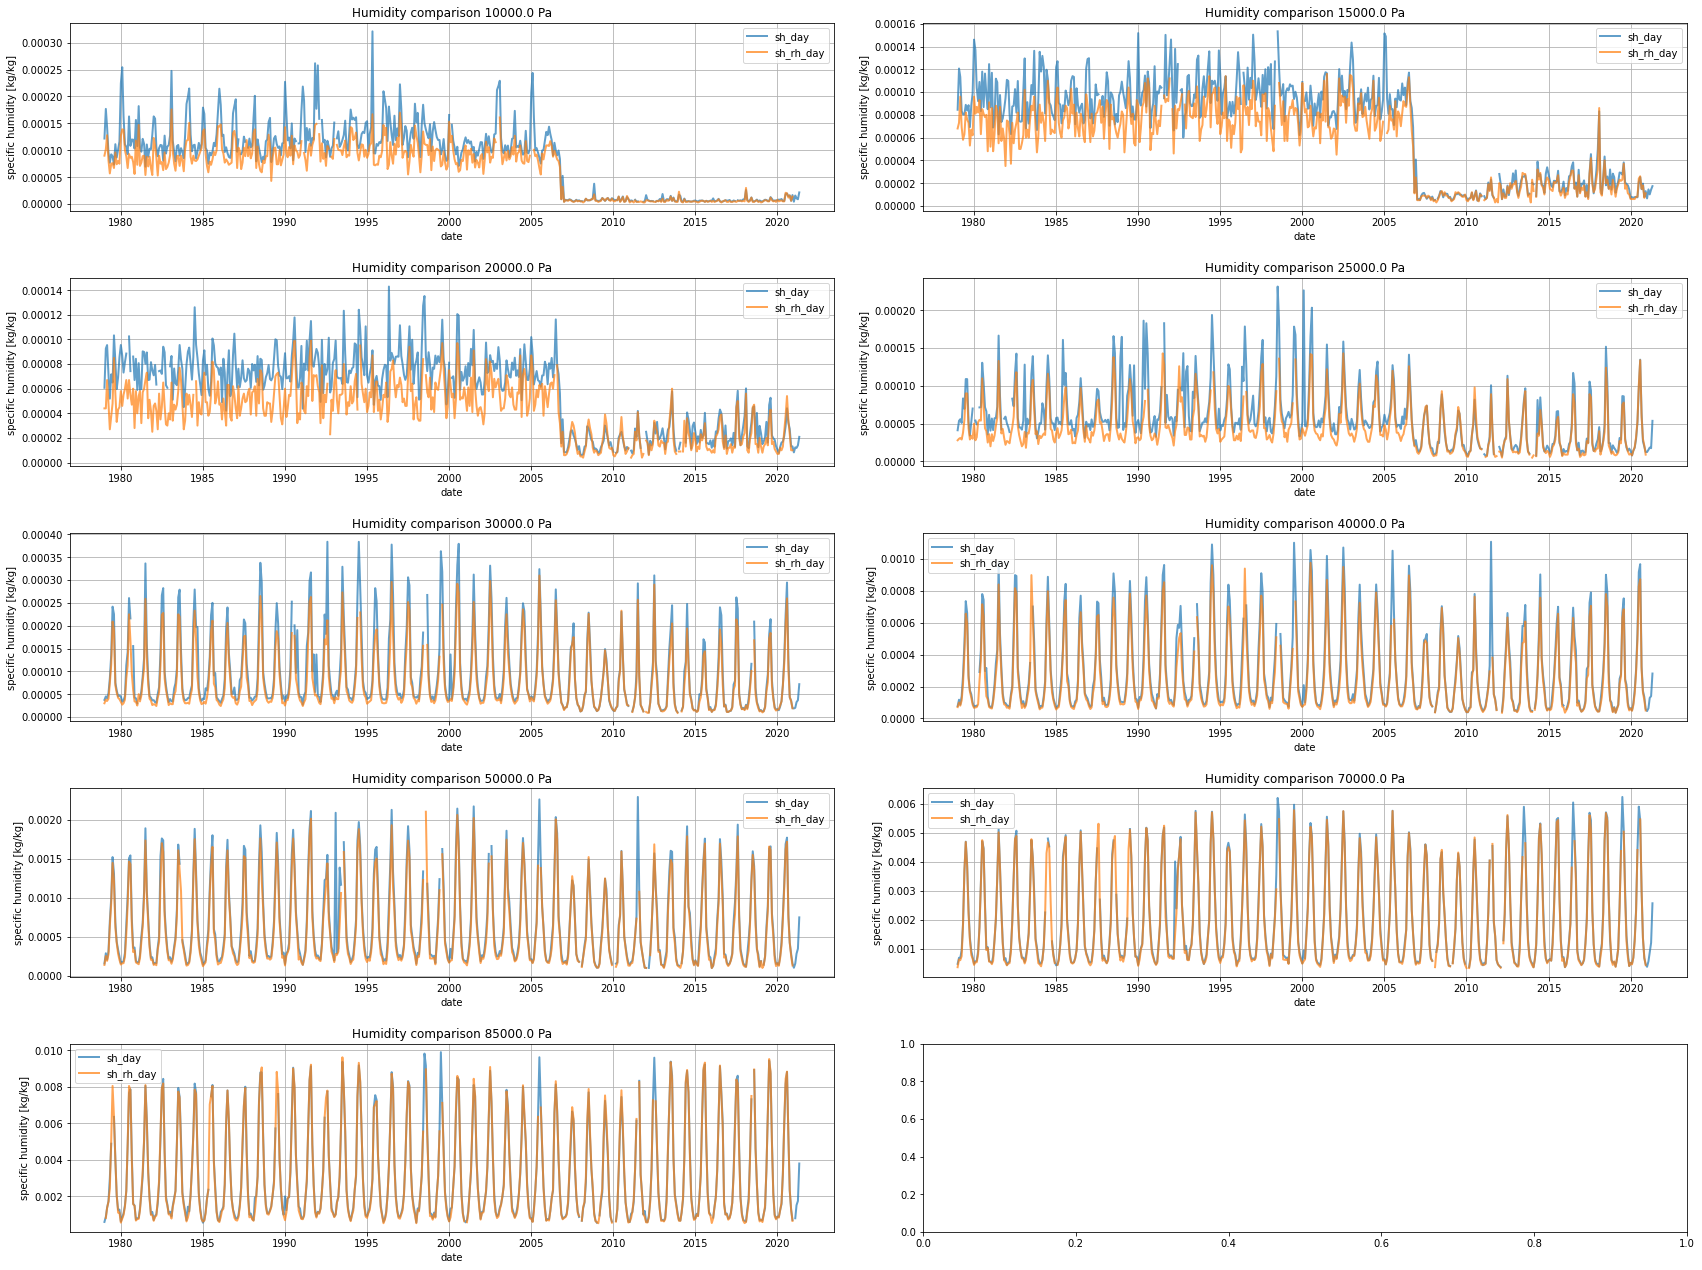

In [51]:
plt.rcParams['figure.figsize'] = [24, 18]


fig, axs = plt.subplots(5, 2)
axs = axs.ravel()
for i in range(len(pressdata[0])):
    axs[i].grid()
    axs[i].set(xlabel='date', ylabel='specific humidity [kg/kg]',
       title='Humidity comparison '+ str(pressdata[0][i])+' Pa')
    for j in [0,1]:
        hum_to_plot = np.array(sh[j])[:,i]
        hum_to_plot[hum_to_plot > np.nanquantile(hum_to_plot, 0.99)] = np.nan
        hum_to_plot[hum_to_plot < np.nanquantile(hum_to_plot, 0.01)] = np.nan
        axs[i].plot(shdates[j], hum_to_plot, label=name[j], linewidth=2, alpha=0.7)

    axs[i].legend()
#     ax2 = axs[i].twinx()
#     ax2.plot(datedata, np.array(tadata)[:,i], color='red', label='adjusted_temperature', linewidth=2, alpha=0.3)
#     ax2.set(xlabel='date', ylabel='temperature [K]')
#     ax2.legend()
fig.tight_layout(pad=2.0)
plt.show()

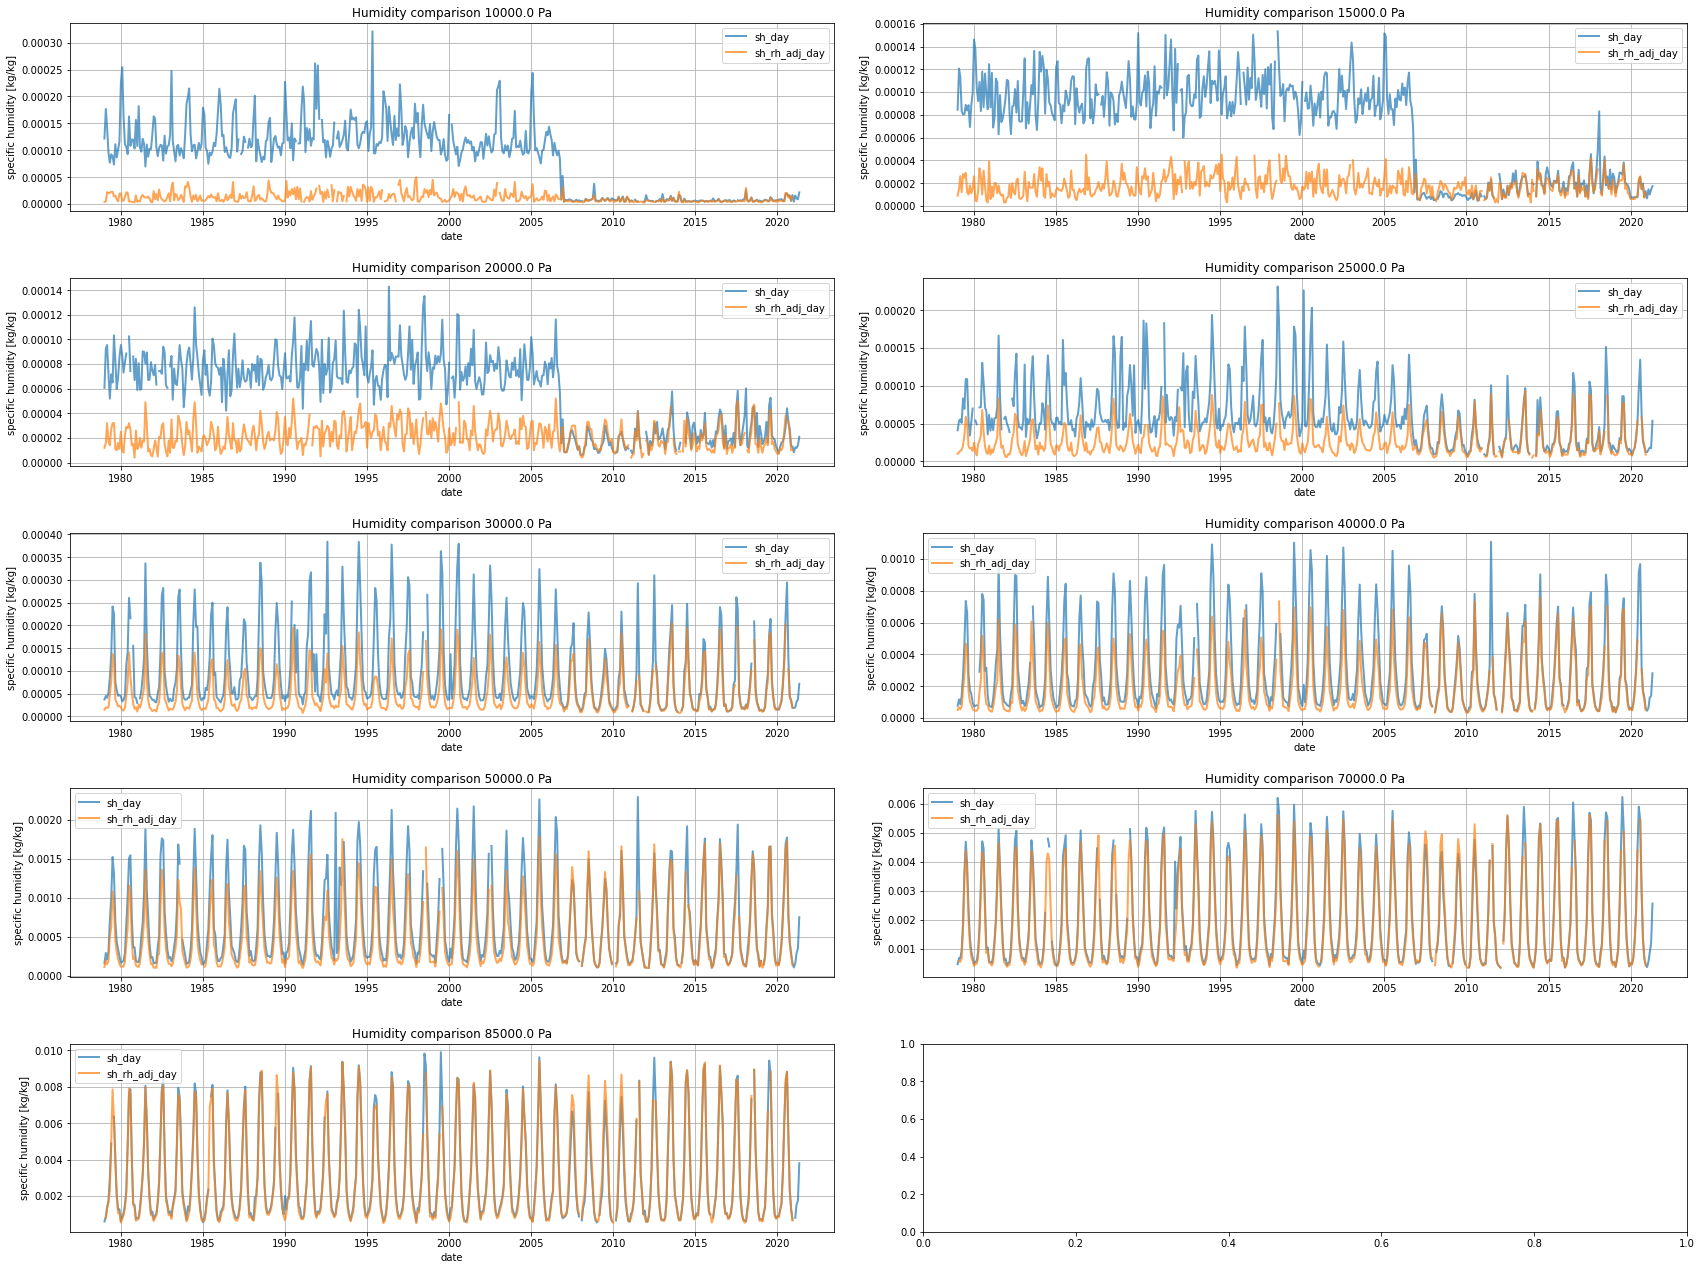

In [52]:
plt.rcParams['figure.figsize'] = [24, 18]


fig, axs = plt.subplots(5, 2)
axs = axs.ravel()
for i in range(len(pressdata[0])):
    axs[i].grid()
    axs[i].set(xlabel='date', ylabel='specific humidity [kg/kg]',
       title='Humidity comparison '+ str(pressdata[0][i])+' Pa')
    for j in [0,2]:
        hum_to_plot = np.array(sh[j])[:,i]
        hum_to_plot[hum_to_plot > np.nanquantile(hum_to_plot, 0.99)] = np.nan
        hum_to_plot[hum_to_plot < np.nanquantile(hum_to_plot, 0.01)] = np.nan
        axs[i].plot(shdates[j], hum_to_plot, label=name[j], linewidth=2, alpha=0.7)

    axs[i].legend()
#     ax2 = axs[i].twinx()
#     ax2.plot(datedata, np.array(tadata)[:,i], color='red', label='adjusted_temperature', linewidth=2, alpha=0.3)
#     ax2.set(xlabel='date', ylabel='temperature [K]')
#     ax2.legend()
fig.tight_layout(pad=2.0)
plt.show()

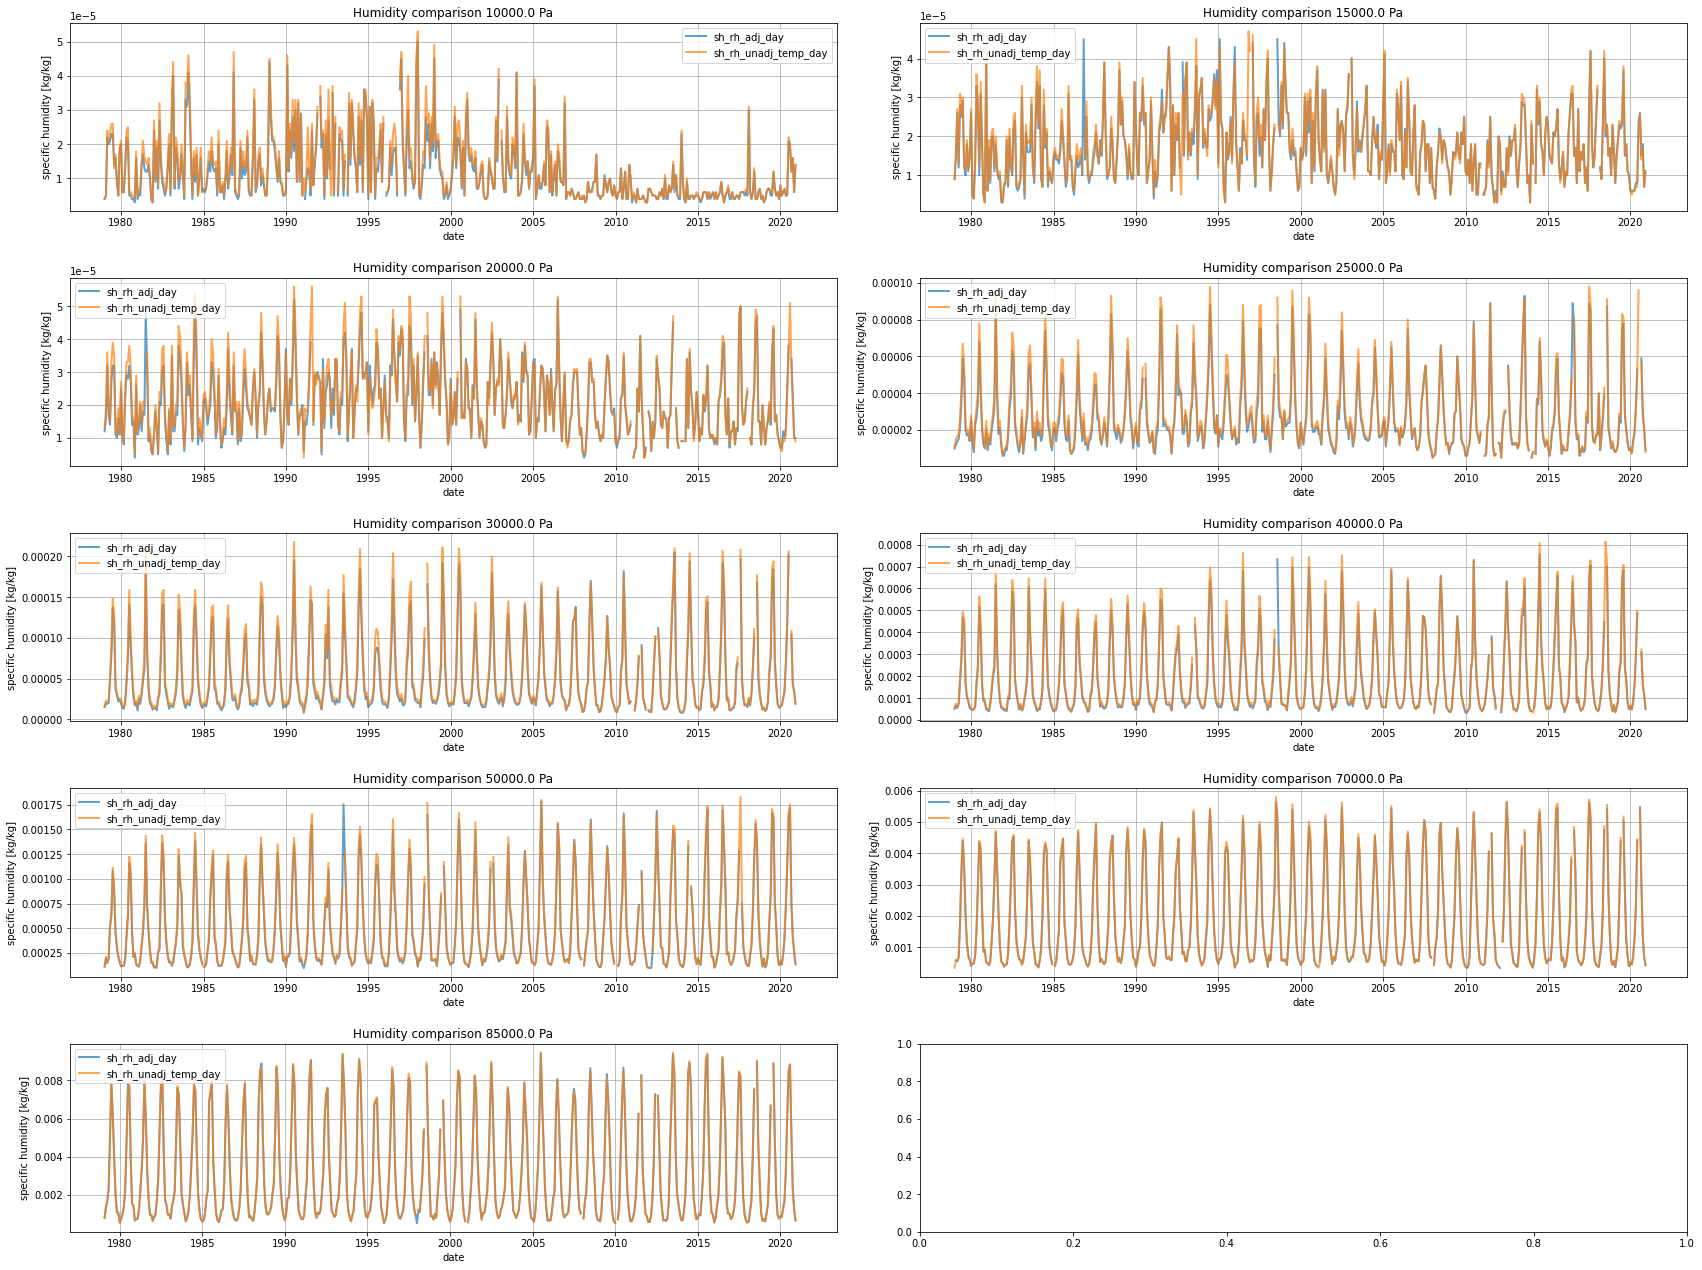

In [54]:
plt.rcParams['figure.figsize'] = [24, 18]


fig, axs = plt.subplots(5, 2)
axs = axs.ravel()
for i in range(len(pressdata[0])):
    axs[i].grid()
    axs[i].set(xlabel='date', ylabel='specific humidity [kg/kg]',
       title='Humidity comparison '+ str(pressdata[0][i])+' Pa')
    for j in [2,3]:
        hum_to_plot = np.array(sh[j])[:,i]
        hum_to_plot[hum_to_plot > np.nanquantile(hum_to_plot, 0.99)] = np.nan
        hum_to_plot[hum_to_plot < np.nanquantile(hum_to_plot, 0.01)] = np.nan
        axs[i].plot(shdates[j], hum_to_plot, label=name[j], linewidth=2, alpha=0.7)

    axs[i].legend()
#     ax2 = axs[i].twinx()
#     ax2.plot(datedata, np.array(tadata)[:,i], color='red', label='adjusted_temperature', linewidth=2, alpha=0.3)
#     ax2.set(xlabel='date', ylabel='temperature [K]')
#     ax2.legend()
fig.tight_layout(pad=2.0)
plt.show()